#Анализ факторов влияющих на стоимость жилья в России

##**1. Введение**

###**Цель исследования:** выявить и проанализировать ключевые факторы, влияющие на стоимость жилой недвижимости в России на основе данных обьявлений за 2018–2021 годы

###**Целевая переменная:** в качестве основной целевой переменной используется цена за квадратный метр, так как она позволяет корректно сравнивать объекты разной площади. Дополнительно анализируется общая стоимость объекта.

### В рамках исследования проводится очистка и подготовка данных, исследовательский анализ (EDA), проверка статистических гипотез и многофакторный анализ для оценки вклада отдельных характеристик жилья

## **2. Загрузка исходного датасета и описание данных**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import math

In [2]:
orig_estate = pd.read_csv('data/all_v2.csv')

In [3]:
orig_estate.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [4]:
orig_estate.dtypes

,0
price,int64
date,object
time,object
geo_lat,float64
geo_lon,float64
region,int64
building_type,int64
level,int64
levels,int64
rooms,int64


##Типы данных
###**Категориальные:**

* **Region** (числовой код, идентифицирующий либо крупный город, такой как Москва или Санкт-Петербург, либо федеральный округ)
* **Building type** (числовой код, идентифицирующий строительный материал: 0 - Прочее, 1 - Панель, 2 - Монолит, 3 - Кирпич, 4 - Блоки, 5 - Дерево)
* **Object type** (тип недвижимости: 1 - вторичное жилье, 11 - новостройка)


###**Количественные:**

* **Area** (общая площадь объекта в кв.м)

* **Kitchen area** (площадь кухни в кв.м)

* **Rooms** (количество комнат, “-1”обозначает квартиру-студию)

* **Level** (этаж, на котором располагается квартира)

* **Levels** (общее количество этажей в доме)


###**Географические:**

* **Geo_lat** (широта)

* **Geo_lon** (долгота)


###**Временные:**

* **Date** (дата публикации объявления)

* **Time** (время публикации)

## **3. Очистка и подготовка данных к анализу**

In [5]:
orig_estate.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06
mean,4.422029e+06,5.403826e+01,5.324433e+01,4.307141e+03,1.948966e+00,6.214530e+00,1.139892e+01,1.726173e+00,5.391825e+01,1.062840e+01,3.945399e+00
std,2.150752e+07,4.622758e+00,2.074763e+01,3.308050e+03,1.038537e+00,4.957419e+00,6.535734e+00,1.082133e+00,3.335293e+01,9.792380e+00,4.558357e+00
min,-2.144967e+09,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,7.000000e-02,1.000000e-02,1.000000e+00
25%,1.950000e+06,5.337768e+01,3.777790e+01,2.661000e+03,1.000000e+00,2.000000e+00,5.000000e+00,1.000000e+00,3.800000e+01,7.000000e+00,1.000000e+00
50%,2.990000e+06,5.517139e+01,4.306774e+01,2.922000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.802000e+01,9.700000e+00,1.000000e+00
75%,4.802000e+06,5.622613e+01,6.564895e+01,6.171000e+03,3.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00,6.313000e+01,1.270000e+01,1.100000e+01
max,2.147484e+09,7.198040e+01,1.625361e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,1.000000e+01,7.856000e+03,9.999000e+03,1.100000e+01


### **Ошибки в данных:**

* Отрицательная цена
* Слишком большая цена (2.15 миллиарда)
* Отрицательное количество комнат (-2)
* Площадь жилья меньше 1 кв.м.
* Площадь кухни больше общей площади объекта
* Огромная площадь кухни (9999 кв.м.)




In [6]:
clean_estate = orig_estate.copy()

###**3.1 Обработка отрицательных и нулевых цен**

In [7]:
negative = clean_estate[clean_estate['price'] < 0]
zero = clean_estate[clean_estate['price'] == 0]

print(f"Отрицательных: {len(negative)}, Нулевых: {len(zero)}")

# print("Примеры отрицательных цен:", negative['price'].head())
print("Статистика отрицательных:", negative[['price', 'area', 'rooms', 'region']].describe())

# Корреляция для проверки "опечатка ли минус"
print("Корреляция area-price (отрицательные):", negative['area'].corr(negative['price']))
print("Корреляция area-|price| (отрицательные):", negative['area'].corr(-negative['price']))  # или .abs()

pos_corr = clean_estate[clean_estate['price'] > 0]['area'].corr(clean_estate[clean_estate['price'] > 0]['price'])
print("Корреляция area-price (положительные):", round(pos_corr,3))

Отрицательных: 365, Нулевых: 23
Статистика отрицательных:               price        area       rooms        region
count  3.650000e+02  365.000000  365.000000    365.000000
mean  -1.738844e+09   77.226274    2.542466   8089.728767
std    5.351311e+08   50.311775    0.852585   2935.548714
min   -2.144967e+09   22.780000   -1.000000      3.000000
25%   -2.114150e+09   56.600000    2.000000   9654.000000
50%   -2.041757e+09   87.390000    3.000000   9654.000000
75%   -1.669967e+09   87.390000    3.000000   9654.000000
max   -4.496730e+07  952.000000    6.000000  13919.000000
Корреляция area-price (отрицательные): -0.22260225454073754
Корреляция area-|price| (отрицательные): 0.22260225454073754
Корреляция area-price (положительные): 0.174


In [8]:
# Обработка аномальных цен
print(f"До обработки: {len(clean_estate)} строк")
print(f"Отрицательных цен: {len(clean_estate[clean_estate['price'] < 0])}")
print(f"Нулевых цен: {len(clean_estate[clean_estate['price'] == 0])}")

# Исправляем отрицательные - берём модуль
clean_estate.loc[clean_estate['price'] < 0, 'price'] = clean_estate[clean_estate['price'] < 0]['price'].abs()

# Удаляем нулевые
clean_estate = clean_estate[clean_estate['price'] > 0].copy()

print(f"После обработки: {len(clean_estate)} строк (удалено нулевых: 23)")

До обработки: 5477006 строк
Отрицательных цен: 365
Нулевых цен: 23
После обработки: 5476983 строк (удалено нулевых: 23)


В датасете обнаружено 365 отрицательных и 23 нулевых значений цены (<0.01% от всех данных).
Анализ показал, что корреляция площади и модуля цены в отрицательных строках (+0.223) близка к корреляции в положительных строках (+0.174), что с высокой вероятностью указывает на техническую ошибку ввода или парсинга данных.
Отрицательные значения исправлены путём взятия абсолютного значения, нулевые - удалены как неисправимые.

Доля таких наблюдений составляет менее 0.01% выборки и не оказывает существенного влияния на общую статистику.

###**3.2 Поставим реалистичные границы на момент 2018-2021**

Ограничения по площади, цене и цене за квадратный метр заданы исходя из рыночных реалий 2018–2021 года и направлены на удаление технических выбросов, а не реальных премиальных объектов. Верхняя граница цены (150 млн руб.) позволяет сохранить элитный сегмент, исключив заведомо ошибочные значения

In [9]:
# Самые критичные и очевидные удаления
print(f"Исходный размер: {clean_estate.shape}")

clean_estate = clean_estate[(clean_estate['area'] >= 18) & (clean_estate['area'] <= 200)]
clean_estate = clean_estate[clean_estate['kitchen_area'] < clean_estate['area']]   # кухня не больше всей площади
clean_estate = clean_estate[clean_estate['kitchen_area'] <= 50]
clean_estate = clean_estate[clean_estate['rooms'] >= -1] # нулевых комнат в данных нет

print(f"После базовой фильтрации: {clean_estate.shape}")

Исходный размер: (5476983, 13)
После базовой фильтрации: (5422888, 13)


In [10]:
# Создаём цену за метр
clean_estate['price_m2'] = (clean_estate['price'] / clean_estate['area']).round(0)

# Жёсткие границы по цене за м2
clean_estate = clean_estate[clean_estate['price_m2'] >= 30_000]
clean_estate = clean_estate[clean_estate['price_m2'] <= 1_500_000]

# По комнатам и этажам
clean_estate = clean_estate[(clean_estate['level'] >= 1) & (clean_estate['levels'] >= 1)]
clean_estate = clean_estate[clean_estate['level'] <= clean_estate['levels']]

# Соотношение кухни с общей площадью
clean_estate = clean_estate[clean_estate['kitchen_area'] <= clean_estate['area'] * 0.55]
clean_estate = clean_estate[clean_estate['kitchen_area'] >= 5]

# Удаляем объекты дороже 150 млн
clean_estate = clean_estate[clean_estate['price'] <= 150_000_000]

print(f"Финальный размер после очистки: {clean_estate.shape}")
print(f"Удалено строк: {len(orig_estate) - len(clean_estate)} ({(len(orig_estate)-len(clean_estate))/len(orig_estate)*100:.1f}%)")


Финальный размер после очистки: (4795875, 14)
Удалено строк: 681131 (12.4%)


In [11]:
print("Мин. цена:", clean_estate['price'].min())
print("Макс. цена:", clean_estate['price'].max())
print("Мин. цена_м2:", clean_estate['price_m2'].min())
print("Макс. цена_м2:", clean_estate['price_m2'].max())
print("Мин. площадь:", clean_estate['area'].min())
print("Макс. площадь:", clean_estate['area'].max())
print("Мин. площадь кухни:", clean_estate['kitchen_area'].min())
print("Макс. площадь кухни:", clean_estate['kitchen_area'].max())

Мин. цена: 540000
Макс. цена: 150000000
Мин. цена_м2: 30000.0
Макс. цена_м2: 1472035.0
Мин. площадь: 18.0
Макс. площадь: 200.0
Мин. площадь кухни: 5.0
Макс. площадь кухни: 50.0


###**3.3 Проверка наличия дубликатов**

In [12]:
clean_estate.duplicated().sum()

np.int64(1378)

In [13]:
clean_estate = clean_estate.drop_duplicates()

In [14]:
clean_estate.duplicated().sum()

np.int64(0)

Доля дубликатов составила менее 0.03%, что не оказывает значимого влияния на результаты

###**3.4 Обработка категориальных переменных**

Замена числовых кодов на текстовые категории позволяет улучшить корректность визуализации и читаемость данных

В столбце 'region' представленны почтовые индексы каждого региона\
Создадим словарь с текстовым названием регионов

In [15]:
print(len(clean_estate['region'].unique()))

84


In [16]:
region_name = {
    2661: 'Санкт-Петербург',
    3446: 'Ленинградская область',
    3: 'Москва',
    81: 'Московская область',
    2843: 'Краснодарский край',
    2871: 'Нижегородская область',
    3230: 'Ростовская область',
    3106: 'Самарская область',
    2922: 'Республика Татарстан',
    2900: 'Ставропольский край',
    2722: 'Республика Башкортостан',
    6171: 'Свердловская область',
    4417: 'Республика Коми',
    5282: 'Челябинская область',
    5368: 'Иркутская область',
    5520: 'Пермский край',
    6817: 'Алтайский край',
    9579: 'Республика Бурятия',
    2604: 'Ярославская область',
    1010: 'Удмуртская Республика',
    7793: 'Псковская область',
    13919: 'Республика Северная Осетия — Алания',
    2860: 'Кемеровская область',
    3019: 'Чувашская Республика',
    4982: 'Республика Марий Эл',
    9648: 'Кабардино-Балкарская Республика',
    5241: 'Республика Мордовия',
    3870: 'Красноярский край',
    3991: 'Тюменская область',
    2359: 'Республика Хакасия',
    9654: 'Новосибирская область',
    2072: 'Воронежская область',
    8090: 'Республика Карелия',
    4007: 'Республика Дагестан',
    11171: 'Республика Саха (Якутия)',
    10160: 'Забайкальский край',
    7873: 'Республика Крым',
    6937: 'Республика Крым',
    2594: 'Кировская область',
    8509: 'Республика Калмыкия',
    11416: 'Республика Адыгея',
    11991: 'Карачаево-Черкесская Республика',
    5178: 'Республика Тыва',
    13913: 'Республика Ингушетия',
    6309: 'Республика Алтай',
    5952: 'Белгородская область',
    6543: 'Архангельская область',
    2880: 'Тверская область',
    5993: 'Пензенская область',
    2484: 'Ханты-Мансийский автономный округ',
    4240: 'Липецкая область',
    5789: 'Владимирская область',
    14880: 'Ямало-Ненецкий автономный округ',
    1491: 'Рязанская область',
    2885: 'Чеченская Республика',
    5794: 'Смоленская область',
    2528: 'Саратовская область',
    4374: 'Вологодская область',
    4695: 'Волгоградская область',
    2328: 'Калужская область',
    5143: 'Тульская область',
    2806: 'Тамбовская область',
    14368: 'Мурманская область',
    5736: 'Новгородская область',
    7121: 'Курская область',
    4086: 'Хабаровский край',
    821: 'Брянская область',
    10582: 'Астраханская область',
    7896: 'Калининградская область',
    8640: 'Омская область',
    5703: 'Курганская область',
    10201: 'Томская область',
    4249: 'Ульяновская область',
    3153: 'Оренбургская область',
    4189: 'Костромская область',
    2814: 'Орловская область',
    13098: 'Камчатский край',
    8894: 'Ивановская область',
    7929: 'Амурская область',
    16705: 'Магаданская область',
    69: 'Еврейская автономная область',
    4963: 'Приморский край',
    1901: 'Сахалинская область',
    61888: 'Ненецкий автономный округ'
}

In [17]:
print(len(region_name))

84


Поменяем названия типа здания, типа обьекта недвижимости и названия регионов с числовых на текстовые

In [18]:
clean_estate['building_type'] = clean_estate['building_type'].map({0: 'Other',
                                                                   1: 'Panel',
                                                                   2: 'Monolith',
                                                                   3: 'Brick',
                                                                   4: 'Blocks',
                                                                   5: 'Wood'})

clean_estate['object_type'] = clean_estate['object_type'].map({1: 'Secondary',
                                                                   11: 'New'})

clean_estate['region'] = clean_estate['region'].map(region_name)

clean_estate.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,price_m2
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,Санкт-Петербург,Panel,8,10,3,82.6,10.8,Secondary,73245.0
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,Московская область,Brick,5,24,2,69.1,12.0,Secondary,125181.0
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,Нижегородская область,Panel,5,9,3,66.0,10.0,Secondary,60606.0
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,Краснодарский край,Blocks,12,16,2,38.0,5.0,New,48684.0
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,Московская область,Brick,13,14,2,60.0,10.0,Secondary,90833.0


###**3.5 Создание новых признаков**

**3.5.1 Для удобства добавим столбец 'year', 'month'**

In [19]:
clean_estate['date'] = pd.to_datetime(clean_estate['date'])

In [20]:
clean_estate['year'] = clean_estate['date'].dt.year
clean_estate['month'] = clean_estate['date'].dt.month
# clean_estate['season'] = clean_estate['month'].map({1:'Зима',2:'Зима',3:'Весна',
#                                                     4:'Весна',5:'Весна',6:'Лето',
#                                                     7:'Лето',8:'Лето',9:'Осень',
#                                                     10:'Осень',11:'Осень',12:'Зима'})
clean_estate = clean_estate.drop(['time'], axis=1)

**3.5.2 Создание категорий этажей**

Признак 'тип этажа' создан для отражения нелинейного влияния этажа на стоимость жилья, так как первый и последний этажи часто имеют меньшую стоимсость относительно средних

In [21]:
clean_estate['floor_type'] = 'Средний'

clean_estate.loc[clean_estate['level'] == 1, 'floor_type'] = 'Первый'
clean_estate.loc[clean_estate['level'] == clean_estate['levels'], 'floor_type'] = 'Последний'

clean_estate['floor_type'] = clean_estate['floor_type'].astype('category')

**3.5.3 Для Москвы и Санкт-Петербурга рассчитаем расстояние до центра города:**

Анализ расстояния до центра выполнен только для Москвы и Санкт-Петербурга, так как для них корректно определен единый городской центр и присутствует достаточный обьем наблюдений

Расчет расстояния по формуле гаверсинуса для точности на сфере

* a = sin²(Δφ/2) + cos(φ1) * cos(φ2) * sin²(Δλ/2)
* c = 2 * atan2(√a, √(1−a))
* d = R * c

где:
φ1, φ2 — широты двух точек в радианах,
Δφ — разница широт,
Δλ — разница долгот,
R — радиус Земли (средний радиус 6371 км).

In [22]:
import math

R = 6371  # радиус Земли в км
MOSCOW_CENTER = (math.radians(55.7558), math.radians(37.6173))
SPB_CENTER = (math.radians(59.9343), math.radians(30.3351))

def dist_to_center_km(row):
    lat_rad = math.radians(row['geo_lat'])
    lon_rad = math.radians(row['geo_lon'])

    if row['region'] == 'Москва':
        lat_center, lon_center = MOSCOW_CENTER
    elif row['region'] == 'Санкт-Петербург':
        lat_center, lon_center = SPB_CENTER
    else:
        return None

    # Формула гаверсинуса
    dlat = lat_center - lat_rad
    dlon = lon_center - lon_rad

    a = math.sin(dlat/2)**2 + math.cos(lat_rad) * math.cos(lat_center) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R*c
    return round(d, 3)


clean_estate['dist_to_center_km'] = clean_estate.apply(dist_to_center_km, axis=1)

## **4. Исследовательский анализ данных (EDA)**

###**4.1 Общая статистика цен**

In [23]:
display(clean_estate[['price_m2', 'area', 'kitchen_area', 'rooms']] \
        .describe(percentiles=[0.01, 0.05, 0.95, 0.99]))

,price_m2,area,kitchen_area,rooms
count,4.794497e+06,4.794497e+06,4.794497e+06,4.794497e+06
mean,8.224246e+04,5.381483e+01,1.081656e+01,1.767525e+00
std,5.794086e+04,2.158824e+01,4.923221e+00,1.007151e+00
min,3.000000e+04,1.800000e+01,5.000000e+00,-1.000000e+00
1%,3.061200e+04,2.400000e+01,5.000000e+00,-1.000000e+00
5%,3.359400e+04,3.000000e+01,5.200000e+00,1.000000e+00
50%,6.420000e+04,4.880000e+01,1.000000e+01,2.000000e+00
95%,1.933330e+05,9.370000e+01,2.000000e+01,3.000000e+00
99%,2.980633e+05,1.315000e+02,2.910000e+01,4.000000e+00
max,1.472035e+06,2.000000e+02,5.000000e+01,9.000000e+00


Распределение цены за м2

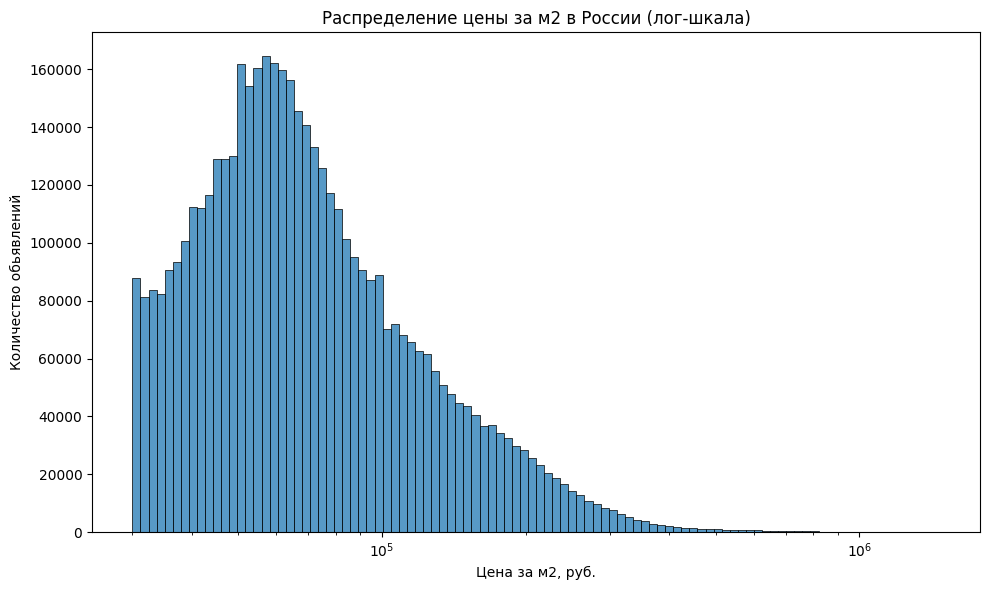

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(clean_estate['price_m2'], bins=100, log_scale=True)
plt.title('Распределение цены за м2 в России (лог-шкала)')
plt.xlabel('Цена за м2, руб.')
plt.ylabel('Количество обьявлений')
plt.tight_layout()
plt.show()

**Вывод** \
Распределение цены за квадратный метр имеет правосторонюю асимметрию. \
Наличие дорогих обьектов приводит к завышению средней цены, поэтому медиана используется как более устойчивая мара оценки и далее применяется в качестве основной метрики при сравнении групп

Распределение общей стоимости обьектов

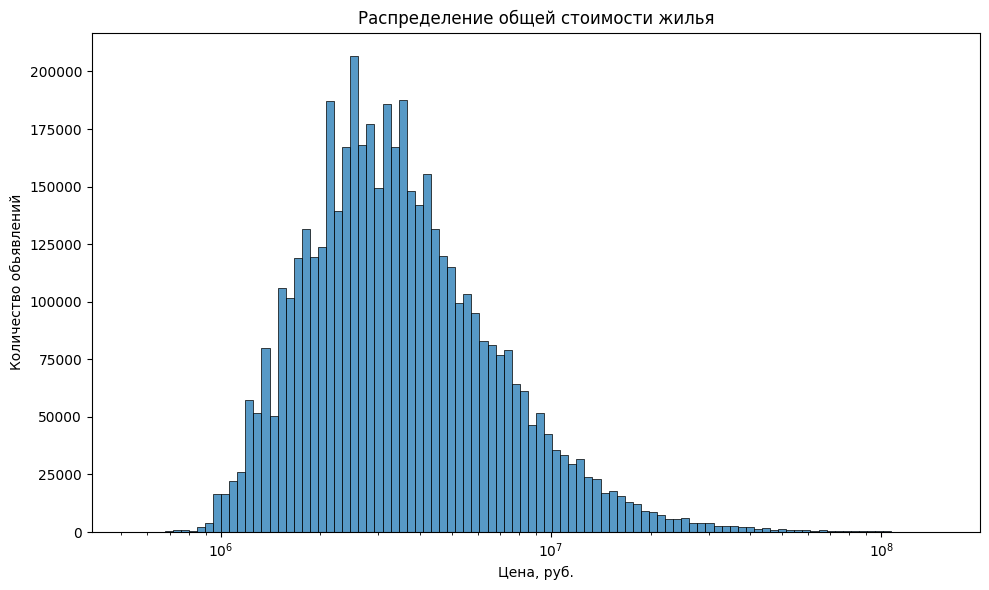

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(clean_estate['price'], bins=100, log_scale=True)
plt.title('Распределение общей стоимости жилья')
plt.xlabel('Цена, руб.')
plt.ylabel('Количество обьявлений')
plt.tight_layout()
plt.show()

Общая стоимость жилья также имеет правосторонюю ассиметрию. Чтобы учесть обьекты разной площади дальшейший анализ будет производиться преимущественно по цене за квадратный метр

### **4.2 Влияние количественных факторов**

**4.2.1 Зависимость цены за квадратный метр от площади**

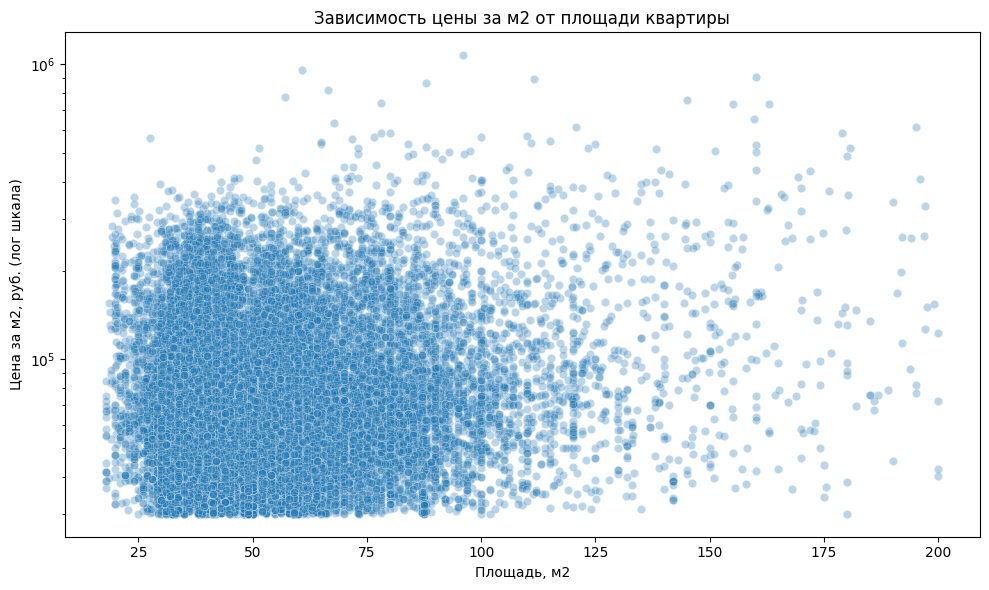

In [26]:
sample = clean_estate.sample(30000, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample, x='area', y='price_m2', alpha=0.3)
plt.yscale('log')
plt.title('Зависимость цены за м2 от площади квартиры')
plt.xlabel('Площадь, м2')
plt.ylabel('Цена за м2, руб. (лог шкала)')
plt.tight_layout()
plt.show()


**Корреляция по всей выборке:**

In [27]:
clean_estate[['area', 'price_m2']].corr()

,area,price_m2
area,1.000000,0.135562
price_m2,0.135562,1.000000


**Москва отдельно:**

In [28]:
msc = clean_estate[clean_estate['region']=='Москва']
msc[['area', 'price_m2']].corr()

,area,price_m2
area,1.000000,0.242944
price_m2,0.242944,1.000000


**Без учета столиц:**

In [29]:
no_capitals = clean_estate[~clean_estate['region'].isin(['Москва', 'Санкт-Петербург'])]
no_capitals[['area', 'price_m2']].corr()

,area,price_m2
area,1.000000,0.026594
price_m2,0.026594,1.000000


**Вывод** \
По всей выборке наблюдается слабая положительная корреляция между площадью квартиры и ценой за квадратный метр (+0.14).
Однако после сегментации данных данная связь в значительной степени обусловлена региональным фактором.
* В Москве корреляция усиливается до +0.24, что может быть связано с концентрацией крупногабаритных квартир в премиальных локациях.
* В остальных регионах России корреляция практически исчезает (+0.03).

Таким образом, площадь квартиры сама по себе оказывает слабое влияние на цену за м2, а наблюдаемая зависимость в агрегированных данных объясняется эффектом агрегации по регионам.

**4.2.2 Влияние количества комнат**

In [30]:
rooms_stats = clean_estate.groupby('rooms')['price_m2'] \
                             .agg(['median', 'mean', 'count']) \
                             .sort_values('median', ascending=False) \
                             .round(0)
display(rooms_stats)

,median,mean,count
rooms,,,
8,102920.0,145179.0,114
6,100000.0,141859.0,1337
7,99356.0,129131.0,320
9,72156.0,97720.0,144
5,72034.0,111648.0,15390
1,65217.0,80996.0,1861538
2,64655.0,82549.0,1652232
3,62500.0,82856.0,951644
4,60547.0,91618.0,135163


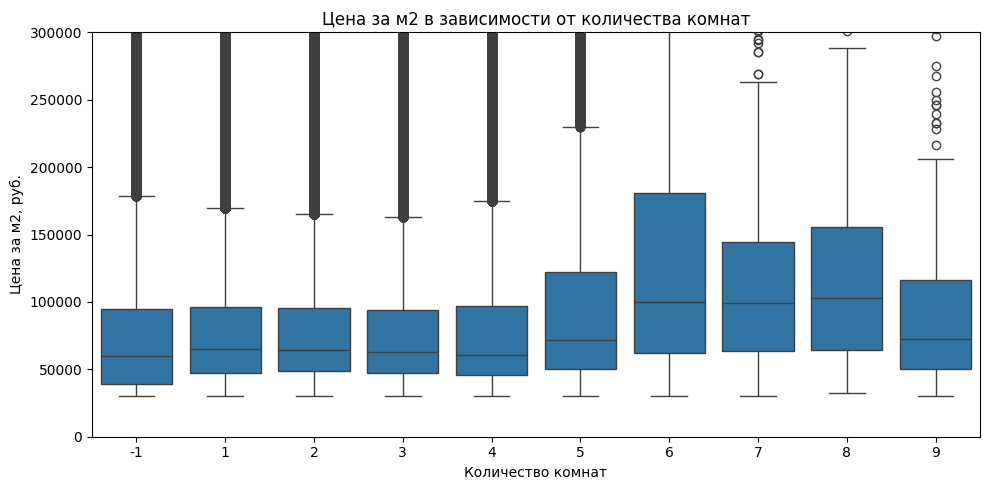

In [31]:
plt.figure(figsize=(10, 5))
ax =sns.boxplot(data=clean_estate, x='rooms', y='price_m2')
ax.set_ylim(0, 300000)
plt.title('Цена за м2 в зависимости от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена за м2, руб.')
plt.tight_layout()
plt.show()

Для массовых сегментов (студии – 4 комнаты) наблюдается снижение цены за м2 с ростом количества комнат тем самым отражая эффект масштаба

Для квартир с 5 и более комнатами медианная цена за м2 резко возрастает. Надежность выводов ограничивает слишком малая выборка в этом сегменте.

**Проверка статистической значимости** \
Используется критерий Краскела-Уоллиса, так как:
* распределение цены за м2 не является нормальным
* размеры групп существенно различаются

In [32]:
groups=[group['price_m2'] for _, group in clean_estate.groupby('rooms')]
kruskal, p_val = stats.kruskal(*groups)

print(f'kruskal: {kruskal:.0f}')
print(f'p-value: {p_val:.3f}')


kruskal: 9582
p-value: 0.000


**Вывод** \
Количество комнат оказывает статистически значимое влияние на цену за квадратный метр жилья
Однако характер этого влияния является нелинейным и существенно различается между массовым и премиальным сегментами рынка

**4.2.3 Влияние доли кухни в общей площади**

Создание относительного признака:

In [33]:
clean_estate['kitchen_ratio'] = clean_estate['kitchen_area'] / clean_estate['area']

Корреляция Спирмена:

In [34]:
sperman, p_val = stats.spearmanr(clean_estate['kitchen_ratio'],
                                 clean_estate['price_m2'])
print(f'sperman: {sperman:.3f}')
print(f'p-value: {p_val:.3f}')

sperman: 0.181
p-value: 0.000


In [35]:
bins = [0, 0.15, 0.25, 0.35, 0.55]
labels = ['до 15%', '15–25%', '25–35%', '35%+']

clean_estate['kitchen_group'] = pd.cut(clean_estate['kitchen_ratio'], bins=bins, labels=labels)

kitchen_stats = (clean_estate.groupby('kitchen_group', observed=True)['price_m2'] \
                             .agg(['median', 'mean', 'count']) \
                             .round(0))

display(kitchen_stats)

,median,mean,count
kitchen_group,,,
до 15%,56250.0,73793.0,1229996
15–25%,65000.0,81553.0,2215200
25–35%,68571.0,85568.0,1078847
35%+,97046.0,113045.0,270454


Между долей кухни в общей площади квартиры и ценой за квадратный метр наблюдается слабая, но статистически значимая положительная связь. Это означает, что квартиры с большей относительной площадью кухни в среднем имеют более высокую цену за м2.

При этом величина коэффициента указывает на то, что данный фактор оказывает умеренное влияние на стоимость жилья и не является определяющим. Статистическая значимость связи во многом объясняется большим объёмом выборки. Практическая значимость признака уступает таким факторам, как регион, локация и тип объекта недвижимости

###**4.3 Влияние категориальных факторов**


**4.3.1 Новостройки или Вторичное жилье**

**Нулевая гипотеза (H0):**
Медианная цена за квадратный метр в новостройках не отличается от медианной цены во вторичном жилье.

**Альтернативная гипотеза (H1):**
Медианные цены за квадратный метр различаются.

Для сравнения цен за квадратный метр в новостройках и на вторичном рынке был использован критерий Манна–Уитни, так как распределение цен является ненормальным, а размеры выборок существенно различаются

In [36]:
new = clean_estate[clean_estate['object_type'] == 'New']['price_m2']
secondary = clean_estate[clean_estate['object_type'] == 'Secondary']['price_m2']

U_m_w, p_val = stats.mannwhitneyu(new, secondary, alternative='two-sided')

print(f'U-test: {U_m_w:.0f}')
print(f'p-value: {p_val:.3f}')

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(
        ((nx - 1)*x.var() + (ny - 1)*y.var()) / (nx + ny - 2)
    )
    return (x.mean() - y.mean()) / pooled_std

cohens = cohens_d(new, secondary)
print(f"cohens_d: {cohens:.3f}")

U-test: 2563416361764
p-value: 0.000
cohens_d: 0.237


Новостройки в среднем дороже вторичного жилья. \
Разница статистически значима, однако размер эффекта умеренный (Cohen's d = 0.237), что говорит о том, что другие факторы, такие как регион, тип дома и этаж, играют более существенную роль в формировании цены за квадратный метр

In [37]:
object_year_stats = (clean_estate.groupby(['year', 'object_type'])['price_m2'] \
                                 .median() \
                                 .reset_index())

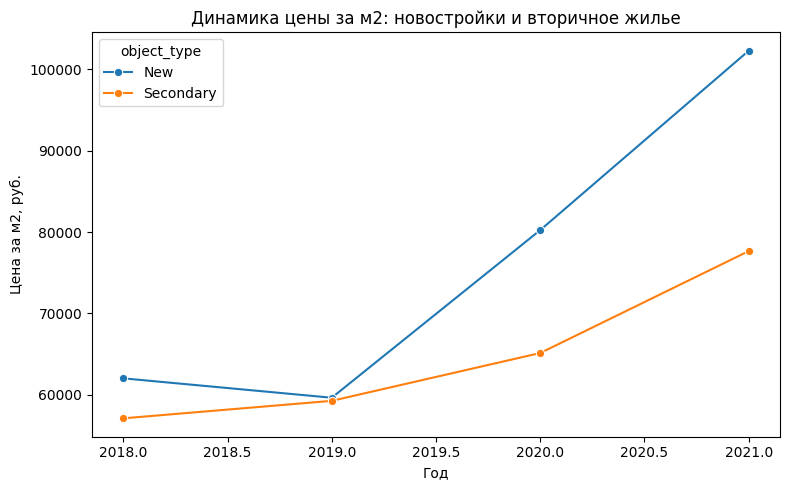

In [38]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=object_year_stats, x='year', y='price_m2', hue='object_type', marker='o')
plt.title('Динамика цены за м2: новостройки и вторичное жилье')
plt.xlabel('Год')
plt.ylabel('Цена за м2, руб.')
plt.tight_layout()
plt.show()

На протяжении 2018–2021 годов новостройки демонстрируют более высокую цену за квадратный метр по сравнению с вторичным жильём. Разрыв особенно увеличивается в 2020–2021 годах, что может быть связано с программами льготной ипотеки и ростом спроса на новое жилье в период пандемии

**4.3.2 Тип этажа**

**Нулевая гипотеза (H0):**
Медианная цена за квадратный метр не зависит от типа этажа

**Альтернативная гипотеза (H1):**
Медианная цена за квадратный метр зависит от типа этажа, хотябы одна группа отличается

In [39]:
floor_stats = (clean_estate.groupby('floor_type', observed=True)['price_m2'] \
                           .agg(['median', 'mean', 'count']) \
                           .round(0))
display(floor_stats)

,median,mean,count
floor_type,,,
Первый,52353.0,63361.0,519277
Последний,56430.0,71501.0,587033
Средний,67692.0,86611.0,3688187


In [40]:
kruskal, p_val = stats.kruskal(*[g['price_m2'] for _, g in clean_estate.groupby('floor_type', observed=True)])

print(f'kruskal: {kruskal:.0f}')
print(f'p-value: {p_val:.3f}')

kruskal: 179129
p-value: 0.000


Результаты теста Краскела–Уоллиса подтверждают, что медианные цены за м2 различаются между этажами (p-value < 0.001) \
При этом размер эффекта заметен: квартиры на первом этаже имеют медианную цену на 22% ниже средних этажей, а последние этажи близки к первым.  
Таким образом, различия не только статистически значимы, но и экономически значимы

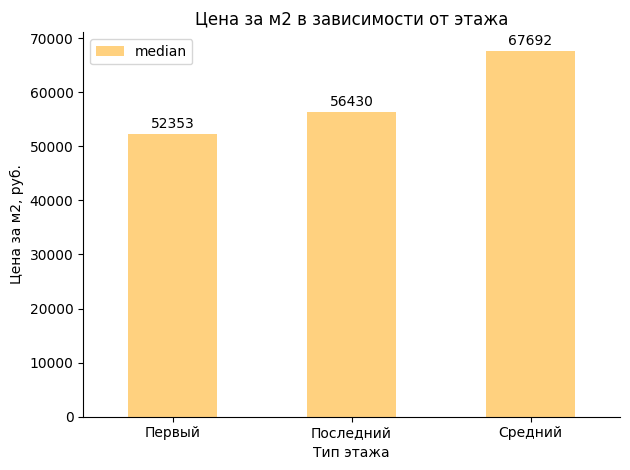

In [41]:
ax = floor_stats.plot(y='median', kind='bar', color='orange', alpha=0.5)
plt.bar_label(ax.containers[0], fmt='%.0f', padding=2)
plt.title('Цена за м2 в зависимости от этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Цена за м2, руб.')
plt.xticks(rotation=0)
plt.tight_layout()
sns.despine()
plt.show()

**4.3.3 Тип здания**

**Нулевая гипотеза (H0):**
Медианная цена за квадратный метр не зависит от типа здания

**Альтернативная гипотеза (H1):**
Медианная цена за квадратный метр зависит от типа здания, хотябы одна группа отличается

In [42]:
building_stats = clean_estate.groupby('building_type')['price_m2'] \
                             .agg(['median', 'mean', 'count']) \
                             .sort_values('median', ascending=False) \
                             .round(0)
display(building_stats)

,median,mean,count
building_type,,,
Monolith,93750.0,115386.0,1073716
Other,71875.0,83028.0,285857
Brick,60484.0,73067.0,1673949
Blocks,57778.0,73744.0,151540
Panel,55134.0,70364.0,1602749
Wood,45534.0,63515.0,6686


In [43]:
kruskal, p_val = stats.kruskal(*[g['price_m2'] for _, g in clean_estate.groupby('building_type')])

print(f'kruskal: {kruskal:.0f}')
print(f'p-value: {p_val:.3f}')

kruskal: 618175
p-value: 0.000


**Вывод** \
Тип дома оказывает статистически значимое влияние на цену за квадратный метр \
Наиболее высокие медианные значения наблюдаются у монолитных домов

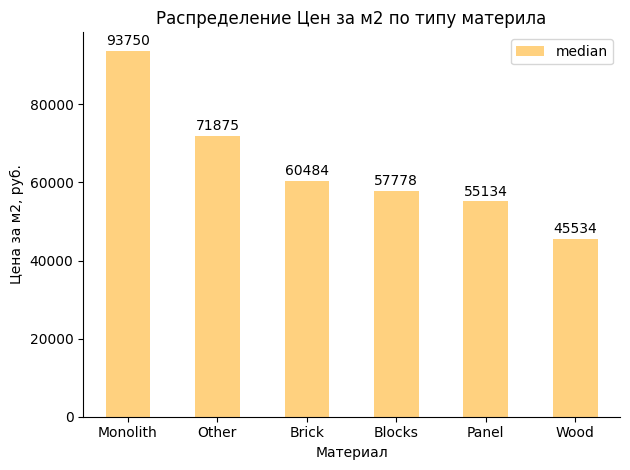

In [44]:
ax = building_stats.plot(y='median', kind='bar', color='orange', alpha=0.5)
plt.bar_label(ax.containers[0], fmt='%.0f', padding=2)
plt.title('Распределение Цен за м2 по типу материла')
plt.xlabel('Материал')
plt.ylabel('Цена за м2, руб.')
plt.xticks(rotation=0)
plt.tight_layout()
sns.despine()
plt.show()

###**4.4 География и локация**

**4.4.1 Различия между регионами**

Топ-10 регионов с дорогой/дешевой ценой за м2

In [45]:
# Распределение по регионам (Топ-10 дорогих/дешевых)
regions_stats = clean_estate.groupby('region')['price_m2'].agg(median_price = 'median',
                                                               mean_price = 'mean',
                                                               count = 'count',
                                                               std_dev = 'std') \
                                                          .sort_values('median_price', ascending=False) \
                                                          .round(0)
display(regions_stats.head(10)) #Топ-10 дорогих

,median_price,mean_price,count,std_dev
region,,,,
Москва,188372.0,206058.0,410146,87950.0
Санкт-Петербург,121429.0,131223.0,445796,49295.0
Московская область,90909.0,93891.0,482522,35828.0
Амурская область,86250.0,86917.0,2079,21347.0
Ленинградская область,86000.0,86031.0,48099,28479.0
Республика Крым,83571.0,89201.0,6605,33571.0
Ямало-Ненецкий автономный округ,77612.0,78722.0,315,33677.0
Архангельская область,75238.0,74560.0,3723,18170.0
Хабаровский край,73633.0,76434.0,1996,31103.0


In [46]:
display(regions_stats.tail(10)) #Топ-10 дешевых

,median_price,mean_price,count,std_dev
region,,,,
Брянская область,43577.0,45517.0,2172,12609.0
Смоленская область,42500.0,44850.0,2804,9931.0
Республика Северная Осетия — Алания,41379.0,43317.0,8291,12485.0
Саратовская область,40780.0,43837.0,6815,12376.0
Республика Марий Эл,39500.0,41522.0,27051,9006.0
Псковская область,39384.0,41582.0,6241,9754.0
Курганская область,39154.0,40506.0,886,7682.0
Челябинская область,39024.0,40846.0,127085,9010.0
Республика Калмыкия,38078.0,40456.0,1970,9679.0


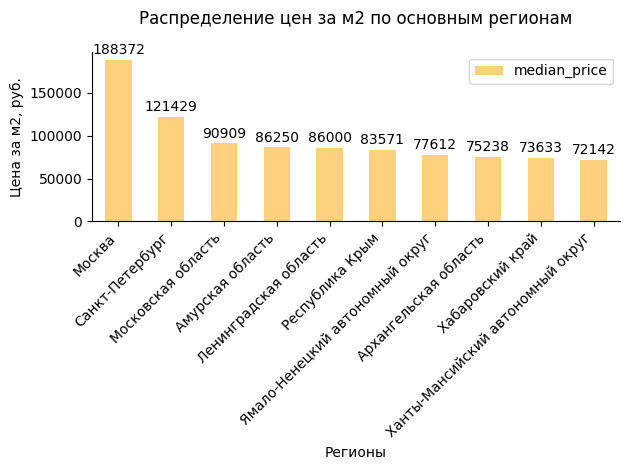

In [47]:
ax = regions_stats.head(10).plot(y='median_price', kind='bar', color='orange', alpha=0.5)
plt.bar_label(ax.containers[0], fmt='%.0f', padding=2)

plt.title('Распределение цен за м2 по основным регионам', pad=20)
plt.xlabel('Регионы')
plt.ylabel('Цена за м2, руб.')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
sns.despine()
plt.show()

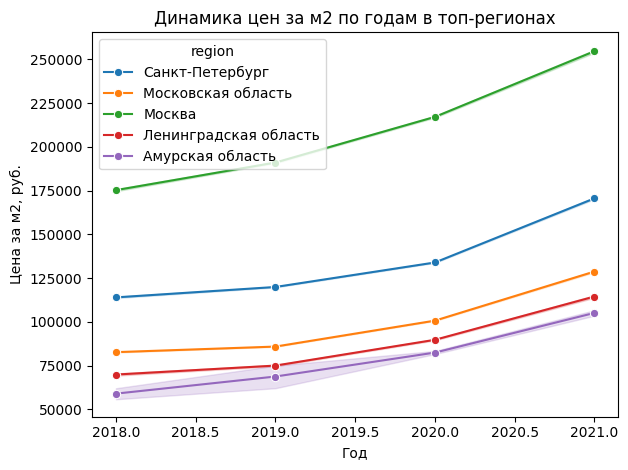

In [48]:
top_regions = regions_stats.index[:5]  # Топ-5

sns.lineplot(data=clean_estate[clean_estate['region'].isin(top_regions)], x='year'
                                                                        , y='price_m2'
                                                                        , hue='region'
                                                                        , marker='o')
sns.set_style("whitegrid")
plt.title('Динамика цен за м2 по годам в топ-регионах')
plt.xlabel('Год')
plt.ylabel('Цена за м2, руб.')
plt.tight_layout()
plt.show()

**Вывод** \
Наиболее высокие цены за м2 наблюдаются в городах федерального значения и регионах с особыми экономическими и климатическими условиями \
В столичных регионах также фиксируется наибольший разброс цен, что отражает различия между центральными и периферийными локациями.

**4.4.2 Расстояние до центра (Москва и Санкт-Петербург)**

Анализ расстояния до центра выполнен только для Москвы и Санкт-Петербурга. В связи с преобладающим количеством обьявлений и четко определенным центром города

In [49]:
msc = clean_estate.query('region == "Москва"')
spb = clean_estate.query('region == "Санкт-Петербург"')

sp_msc, p_val = stats.spearmanr(msc['dist_to_center_km'], msc['price_m2'])

print(f'Spearmen_msc: {sp_msc:.3f}')
print(f'p_value_msc: {p_val:.3f}')

sp_spb, p_val = stats.spearmanr(spb['dist_to_center_km'], spb['price_m2'])

print(f'Spearmen_spb: {sp_spb:.3f}')
print(f'p_value_spb: {p_val:.3f}')

Spearmen_msc: -0.603
p_value_msc: 0.000
Spearmen_spb: -0.381
p_value_spb: 0.000


**Вывод** \
В пределах города наблюдается устойчивая отрицательная связь между расстоянием до центра и ценой за м2.
Для Москвы коэффициент корреляции Спирмена составляет около −0.6, что указывает на значимую роль центральности локации

In [50]:
suspicious = clean_estate[(clean_estate['dist_to_center_km'] < 0.1)
                             &
                            (clean_estate['price_m2'] < 100_000)]

suspicious[['price', 'area', 'rooms', 'building_type']]

,price,area,rooms,building_type
310810,2000000,49.3,2,Panel
387490,2470000,57.0,1,Monolith
454758,1750000,58.0,3,Brick
485177,1450000,37.0,1,Panel
797424,1050000,32.0,1,Brick
1046955,2630000,60.0,3,Panel
1325475,2000000,32.2,1,Panel
2222038,3658000,52.0,1,Brick
2982838,2200000,60.0,4,Brick
3323193,2400000,36.0,1,Blocks


Вблизи центра присутствуют отдельные объекты с аномально низкой ценой. Это может быть связано с особенностями объекта (старый фонд, первый этаж, состояние) либо ошибками при записи координат здания

### **4.5 Временные факторы**

**4.5.1 Динамика цен по годам**

In [51]:
yearly_stats = clean_estate.groupby('year')['price_m2'].agg(median_price = 'median',
                                                            mean_price = 'mean',
                                                            count = 'count')

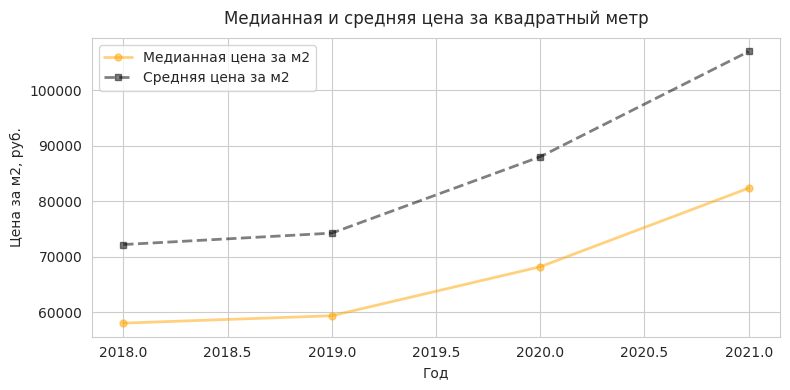

In [52]:
plt.figure(figsize=(8, 4))

median_line = plt.plot(yearly_stats.index, yearly_stats['median_price'],
                       marker='o', linewidth=2, markersize=5,
                       color='orange', alpha=0.5, label='Медианная цена за м2')  # Оранжевый

mean_line = plt.plot(yearly_stats.index, yearly_stats['mean_price'],
                     marker='s', linewidth=2, markersize=5, linestyle='--',
                     color='black', alpha=0.5, label='Средняя цена за м2')  # Черный

plt.title('Медианная и средняя цена за квадратный метр',
          fontsize=12, pad=10)
plt.xlabel('Год', fontsize=10)
plt.ylabel('Цена за м2, руб.', fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [53]:
# Динамика цены за м2 и количества предложений в процентах
yearly_stats['increase'] = (yearly_stats['median_price'].pct_change() * 100).round(0) #Динамика цен
yearly_stats['supply'] = (yearly_stats['count'].pct_change() * 100).round(0) #Динамика предложения
display(yearly_stats)

,median_price,mean_price,count,increase,supply
year,,,,,
2018,58000.0,72171.339726,725684,NaN,NaN
2019,59333.0,74234.688916,1896630,2.0,161.0
2020,68167.0,88008.706447,1647049,15.0,-13.0
2021,82353.0,106996.065332,525134,21.0,-68.0


* Наблюдается динамика роста на протяжении всего времени
* Наибольшие темпы роста относительно прошлого года достигнуты в 2020 и 2021 годах (15%) и (21%) соответственно
* В 2020 году предложение на рынке недвижимости относительно прошлого года упало на 13%. Данные 2021 представленны лишь до 1 мая, что не позволяет судить о разнице в предложении 2021 года относительно 2020 года.

Вероятно темпы роста цен за м2 и спад предложения связан с пандемией COVID

## **5. Многофакторный анализ факторов стоимости жилья**

###**5.1 Цель многофакторного анализа**

Целью данного этапа является оценка вклада каждого фактора в стоимость жилья при прочих равных условиях

В отличие от EDA, где факторы анализировались по отдельности, регрессионная модель позволяет:
* контролировать влияние других переменных,
* определить относительную важность факторов,
* получить количественную интерпретацию эффекта каждого признака.

###**5.2 Выбор модели и целевой переменной**


Распределение price_m2 имеет выраженную правостороннюю асимметрию и гетероскедастичность.
В связи с этим используется логарифм целевой переменной:

In [54]:
clean_estate['log_price_m2'] = np.log(clean_estate['price_m2'])

In [55]:
clean_estate.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,price_m2,year,month,floor_type,dist_to_center_km,kitchen_ratio,kitchen_group,log_price_m2
0,6050000,2018-02-19,59.805808,30.376141,Санкт-Петербург,Panel,8,10,3,82.6,10.8,Secondary,73245.0,2018,2,Средний,14.47,0.130751,до 15%,11.201565
1,8650000,2018-02-27,55.683807,37.297405,Московская область,Brick,5,24,2,69.1,12.0,Secondary,125181.0,2018,2,Средний,NaN,0.173661,15–25%,11.737516
2,4000000,2018-02-28,56.295250,44.061637,Нижегородская область,Panel,5,9,3,66.0,10.0,Secondary,60606.0,2018,2,Средний,NaN,0.151515,15–25%,11.012149
3,1850000,2018-03-01,44.996132,39.074783,Краснодарский край,Blocks,12,16,2,38.0,5.0,New,48684.0,2018,3,Средний,NaN,0.131579,до 15%,10.793106
4,5450000,2018-03-01,55.918767,37.984642,Московская область,Brick,13,14,2,60.0,10.0,Secondary,90833.0,2018,3,Средний,NaN,0.166667,15–25%,11.416778


###**5.3 Подготовка признаков**

В модель включены признаки, показавшие значимое влияние на предыдущих этапах анализа: \
**Количественные**
* area
* rooms
* kichen_ratio

**Категориальные**
* object_type
* building_type
* floor_type
* year

Подготовка данных:

In [56]:

model_df = clean_estate.copy()

# Топ-10 регионов по количеству объявлений
top_regions = model_df['region'].value_counts().head(10).index
model_df['region_grouped'] = np.where(model_df['region'].isin(top_regions),
                                      model_df['region'],
                                      'Other')

# Отбор столбцов
model_df = model_df[['log_price_m2',
                     'area',
                     'rooms',
                     'kitchen_ratio',
                     'object_type',
                     'building_type',
                     'floor_type',
                     'year',
                     'region_grouped']]

# Удаление пропусков
model_df = model_df.dropna()


###**5.4 Кодирование категориальных переменных**

Используется one-hot encoding с удалением базовой категории:

In [57]:
X = pd.get_dummies(
    model_df.drop('log_price_m2', axis=1),
    drop_first=True)

X = sm.add_constant(X).astype(float)
y = model_df['log_price_m2'].astype(float)


###**5.5 Обучение модели**

Используется OLS-регрессия с робастными стандартными ошибками (HC3)
Это позволяет корректно учитывать гетероскедастичность, характерную для ценовых данных

In [58]:
model = sm.OLS(y, X).fit(cov_type='HC3')

In [59]:

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_price_m2   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                 4.718e+05
Date:                Tue, 10 Feb 2026   Prob (F-statistic):               0.00
Time:                        09:43:57   Log-Likelihood:            -1.0374e+06
No. Observations:             4794497   AIC:                         2.075e+06
Df Residuals:                 4794474   BIC:                         2.075e+06
Df Model:                          22                                         
Covariance Type:                  HC3                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 -203.4647      0.332   -612.862      0.000    -204.115    -202.814
area                                     0.0019   1.22e-05    155.394      0.000       0.002       0.002
rooms                                   -0.0204      0.000    -85.372      0.000      -0.021      -0.020
kitchen_ratio                            0.5683      0.002    263.556      0.000       0.564       0.572
year                                     0.1059      0.000    644.358      0.000       0.106       0.106
object_type_Secondary                    0.1222      0.000    352.583      0.000       0.122       0.123
building_type_Brick                      0.0291      0.001     35.749      0.000       0.028       0.031
building_type_Monolith                   0.1497      0.001    174.480      0.000       0.148       0.151
building_type_Other                      0.1629      0.001    171.797      0.000       0.161       0.165
building_type_Panel                     -0.0621      0.001    -75.526      0.000      -0.064      -0.060
building_type_Wood                      -0.1429      0.004    -34.444      0.000      -0.151      -0.135
floor_type_Последний                     0.0397      0.001     67.761      0.000       0.039       0.041
floor_type_Средний                       0.1203      0.000    267.485      0.000       0.119       0.121
region_grouped_Краснодарский край        0.0862      0.001    158.865      0.000       0.085       0.087
region_grouped_Москва                    1.2513      0.001   2086.756      0.000       1.250       1.252
region_grouped_Московская область        0.5009      0.001    859.563      0.000       0.500       0.502
region_grouped_Новосибирская область     0.0814      0.000    180.669      0.000       0.081       0.082
region_grouped_Республика Татарстан      0.2596      0.001    375.196      0.000       0.258       0.261
region_grouped_Ростовская область        0.0341      0.001     57.826      0.000       0.033       0.035
region_grouped_Санкт-Петербург           0.7837      0.000   1578.414      0.000       0.783       0.785
region_grouped_Свердловская область      0.1851      0.001    285.437      0.000       0.184       0.186
region_grouped_Тюменская область         0.1403      0.001    216.774      0.000       0.139       0.142
region_grouped_Челябинская область      -0.2369      0.001   -401.020      0.000      -0.238      -0.236
==============================================================================
Omnibus:                   175700.309   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           367441.559
Skew:                           0.253   Prob(JB):                         0.00
Kurtosis:                       4.259

Модель объясняет около 68% вариации цены за квадратный метр, что является высоким значением для кросс-секционных данных рынка недвижимости

###**5.6 Интерпритация коэффициентов**

Для удобства интерпритации переведем коэффициенты в проценты: \
coef_% = (e^(coef)-1)*100

In [60]:
coef_df = pd.DataFrame({'coef': model.params,
                        'p_value': model.pvalues})

coef_df['effect_%'] = (np.exp(coef_df['coef']) - 1) * 100
coef_df = coef_df.sort_values('effect_%', ascending=False).round(2)
coef_df

,coef,p_value,effect_%
region_grouped_Москва,1.25,0.0,249.49
region_grouped_Санкт-Петербург,0.78,0.0,118.95
kitchen_ratio,0.57,0.0,76.52
region_grouped_Московская область,0.50,0.0,65.02
region_grouped_Республика Татарстан,0.26,0.0,29.64
region_grouped_Свердловская область,0.19,0.0,20.33
building_type_Other,0.16,0.0,17.69
building_type_Monolith,0.15,0.0,16.15
region_grouped_Тюменская область,0.14,0.0,15.06
object_type_Secondary,0.12,0.0,13.00


##**Количественные признаки**

**Площадь** \
Увеличение площади квартиры на 1 м2 связано с ростом цены за м2 примерно на 0.2%

**Количество комнат** \
При прочих равных увеличение количества комнат снижает цену за м2, что отражает эффект масштабирования в массовом сегменте.

**Доля кухни** \
Увеличение доли кухни на 10% связано с ростом цены за м2 примерно на 7-8%

##**Временной фактор**
**Год** \
В 2018-2021г наблюдается устойчивый рост цен на жилье, в среднем около 11% в год

##**Категориальные факторы**
**Новостройки и вторичный рынок** \
Базовая категория - Новостройки \
После контроля региона, года и характеристик жилья вторичное жилье оказывается дороже. Это указывает на то, что эффект "новостроеки дороже" в EDA объясняется региональной и временной структурой предложения

**Этаж** \
Базовая категория - Первый \
Квартиры на средних этажах имеют наибольшую стоимость, первые этажи - наименее привлекательны

**Тип здания** \
Базовая категория - Blocks \
Тип здания оказывает заметное влияние на цену за квадратный метр: наиболее дорогими являются квартиры в монолитных домах (16%), тогда как панельные и деревянные дома характеризуются более низкой стоимостью за м2

**Регион** \
Базовая категория - Other \
Регион является ключевым драйвером стоимости жилья и превосходит по влиянию все характеристики квартиры

###**5.7 Проверка мультиколлинеарности**

Для проверки мультиколлинеарности была рассчитана статистика VIF

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])]

vif_df.sort_values('VIF', ascending=False)

,feature,VIF
0,const,5.513469e+06
9,building_type_Panel,8.141682e+00
6,building_type_Brick,8.120994e+00
7,building_type_Monolith,6.649622e+00
8,building_type_Other,2.820878e+00
2,rooms,2.513250e+00
1,area,2.324652e+00
12,floor_type_Средний,1.940040e+00
11,floor_type_Последний,1.880137e+00
16,region_grouped_Новосибирская область,1.522847e+00


Для всех объясняющих переменных (за исключением константы) значения VIF не превышают 8. Это указывает на отсутствие критической мультиколлинеарности.
Повышенные значения VIF для дамми-переменных типа здания объясняются их принадлежностью к одной категориальной группе и не оказывают негативного влияния на стабильность коэффициентов модели

## **6. Ограничения исследования**
* Данные представленны с 19.02.2018 по 01.05.2021
* Используются данные обьявлений, а не сделок. Из-за этого цены могу быть завышены
* Отсутствие данных о состоянии здания, годе постройки дома, о состоянии квартиры (ремонт, отделка), транстпортной доступности
* Координаты могут содержать ошибки
* Из-за крайне большого обьема данных даже слабые эффекты оказываются статистически значимыми. Поэтому при интерпретации результатов основной акцент делается на величину эффекта и его экономическую значимость, а не только на значения p-value